# KERNEL CLEAN

In [1]:
%reset -f -s

import gc

# LIBRARIES IMPORT

In [2]:
# imports

import CNN_lib
import CNN_utilities
import fig_lib 

import numpy as np
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
d_type='processed'     # 'processed', 'synthetic'
video_d=True            # Video = True , Image = False 
test_data,number_data_points= False,500

t_btw_frm=0.05

checking_on=False

data_augmentation= True

checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/model_checkpoint.h5"

if d_type=='processed' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'  
elif d_type=='synthetic' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/synthetic_train_d.pkl'   
     

# CNN

### GENERATE TRAIN DATA

In [4]:
# X_train,Y_train

with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,rcs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]


### CHECK 1

In [5]:
if checking_on:

    for x,y,r in zip(x_train,y_train,rcs):
        print(r,int(y),np.shape(x),type(x))

In [6]:
if checking_on:

    rec_elm='I70'
    idx=rcs.index(rec_elm)
    y_train[idx]

In [7]:
if checking_on:fig_lib.vid_show(x_train[idx],t_btw_frm=t_btw_frm)

In [8]:
if test_data:

    total_data_points=len(y_train)
    test_len=total_data_points-number_data_points
    
    Xx_train=x_train[0:number_data_points]
    Yy_train=y_train[0:number_data_points]
    rcs=rcs[0:number_data_points]

else:

    Xx_train=x_train
    Yy_train=y_train


## DATA SHUFFLE 1

In [9]:
idx_permut = np.random.permutation(len(Xx_train))
Xx_train,Yy_train=Xx_train[idx_permut],Yy_train[idx_permut]
recs=list(np.take(rcs, idx_permut))


### CHECK 2

In [10]:
if checking_on:

    rec_elm='AUG_I70'
    idx=recs.index(rec_elm)
    print(idx,Yy_train[idx])

In [11]:
if checking_on:fig_lib.vid_show(Xx_train[idx],t_btw_frm=t_btw_frm)

### DATA SPLIT

In [12]:
test_size=0.2

X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl = train_test_split(Xx_train, Yy_train, test_size=test_size, shuffle=False) #,random_state=42)

print('Train data:',len(Y_train_spl),'Evaluation data:',len(Y_eval_spl))
if test_data:print('Test_len:',test_len)

Train data: 528 Evaluation data: 132


 Train data shape: (528, 40, 160, 160, 1)  Validation data shape: (132, 40, 160, 160, 1)


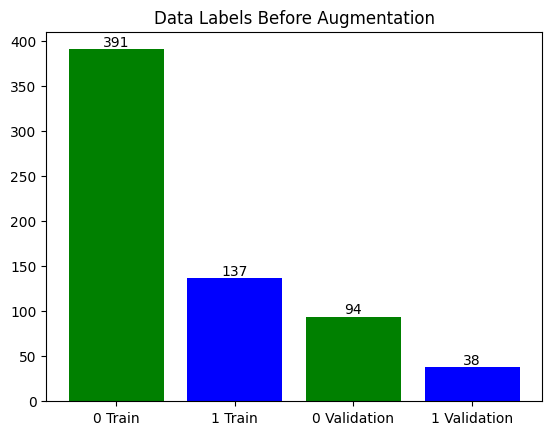

In [13]:
# check data

zeros_count = np.sum(Y_train_spl == 0)
ones_count = np.sum(Y_train_spl == 1)
zeros_count_val = np.sum(Y_eval_spl == 0)
ones_count_val = np.sum(Y_eval_spl == 1)

labels = ['0 Train', '1 Train','0 Validation', '1 Validation']
print(' Train data shape:', np.shape(X_train_spl),' Validation data shape:', np.shape(X_eval_spl))

plt.bar(labels, [zeros_count, ones_count,zeros_count_val,ones_count_val], color=['green', 'blue','green', 'blue'])

for i, count in enumerate([zeros_count, ones_count,zeros_count_val,ones_count_val]):

    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.title('Data Labels Before Augmentation')
plt.show()

# DATA AUGMENTATION

In [14]:
if data_augmentation:
    
    number_train_aug_1=120
    number_train_aug_0=20

    number_validation_aug_1=10
    number_validation_aug_0=4

In [15]:
#video = tf.image.random_brightness(video, max_delta=0.9)    # OK
#video = tf.image.random_contrast(video, lower=0.5, upper=10)   # OK

if data_augmentation:

    aug_X_train_1,aug_Y_train_1,aug_train_recs_1=CNN_lib.main_aug_f(number_train_aug_1,X_train_spl,Y_train_spl,recs,label=1)
    aug_X_train_0,aug_Y_train_0,aug_train_recs_0=CNN_lib.main_aug_f(number_train_aug_0,X_train_spl,Y_train_spl,recs,label=0)

    aug_X_eval_1,aug_Y_eval_1,aug_eval_recs_1=CNN_lib.main_aug_f(number_validation_aug_1,X_eval_spl,Y_eval_spl,recs,label=1)
    aug_X_eval_0,aug_Y_eval_0,aug_eval_recs_0=CNN_lib.main_aug_f(number_validation_aug_0,X_eval_spl,Y_eval_spl,recs,label=0)

In [16]:
if data_augmentation:

    X_train_spl = np.concatenate((X_train_spl, aug_X_train_1,aug_X_train_0), axis=0)
    Y_train_spl = np.concatenate((Y_train_spl, aug_Y_train_1, aug_Y_train_0))
    
    X_eval_spl = np.concatenate((X_eval_spl, aug_X_eval_1,aug_X_eval_0), axis=0)
    Y_eval_spl = np.concatenate((Y_eval_spl, aug_Y_eval_1, aug_Y_eval_0))
    
    recs = recs+aug_train_recs_1+aug_train_recs_0+aug_eval_recs_1+aug_eval_recs_0

    print(X_train_spl.shape,Y_train_spl.shape)
    print(X_eval_spl.shape,Y_eval_spl.shape)


(668, 40, 160, 160, 1) (668,)
(146, 40, 160, 160, 1) (146,)


### DATA SHUFFLE 2

In [17]:
if data_augmentation:

    
    final_recs=recs

    X_train,Y_train=CNN_lib.shuffle(X_train_spl,Y_train_spl)
    X_eval,Y_eval=CNN_lib.shuffle(X_eval_spl,Y_eval_spl)
    
else:

    Y_train = Y_train_spl
    X_train = X_train_spl
    X_eval=X_eval_spl
    Y_eval=Y_eval_spl
    final_recs = recs

 Train data shape: (668,)  Validation data shape: (146,)


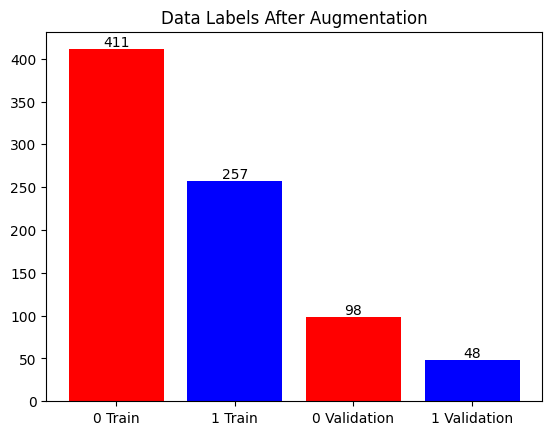

In [18]:
# check data
if data_augmentation:

    zeros_count = np.sum(Y_train == 0)
    ones_count = np.sum(Y_train == 1)
    zeros_count_val = np.sum(Y_eval == 0)
    ones_count_val = np.sum(Y_eval == 1)

    labels = ['0 Train', '1 Train','0 Validation', '1 Validation']
    print(' Train data shape:', np.shape(X_train),' Validation data shape:', np.shape(X_eval))

    plt.bar(labels, [zeros_count, ones_count,zeros_count_val,ones_count_val], color=['red', 'blue','red', 'blue'])

    for i, count in enumerate([zeros_count, ones_count,zeros_count_val,ones_count_val]):

        plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

    plt.title('Data Labels After Augmentation')
    plt.show()

#  CNN

In [19]:
print('LIBRARY MODELS:')
print(' ')

for model_name in CNN_lib.MODELS.values(): print(model_name)

LIBRARY MODELS:
 
image_full
image_conv
image_conv_augmentation
video_conv2D
video_conv3D


In [20]:
# -------- CNN PARAMS --------

# -------- MODEL --------

model_from_CNN_lib,mdl= False,'video_conv3D'

opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epch=9


### MODEL

In [21]:
gc.collect()

6281

In [22]:
# MODEL 

if model_from_CNN_lib:
  
  if video_d: model = CNN_lib.lib_models(mdl,im_input_shp=(max_frm_n, HEIGHT, WIDTH, 1))
  else: model = CNN_lib.lib_models(mdl,im_input_shp=(HEIGHT, WIDTH,1))

else:

  model = models.Sequential([
          layers.Conv3D(filters=16, kernel_size=(3, 3, 3), activation='relu',input_shape=(max_frm_n, HEIGHT, WIDTH, 1)),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.Dropout(0.2),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(3, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=16, kernel_size=(1, 3, 3),  activation='relu'),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(64, activation='relu'),
          layers.Dense(1,activation='sigmoid')
          ])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 38, 158, 158, 16   448       
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 19, 79, 79, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 19, 77, 77, 32)    4640      
                                                                 
 dropout (Dropout)           (None, 19, 77, 77, 32)    0         
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 9, 38, 38, 32)     0         
 g3D)                                                            
                                                       

In [23]:
model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])

In [24]:
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss',   mode='min', verbose=1)            


### TRAINNING

In [25]:
history =model.fit(X_train, Y_train, epochs=epch, validation_data=(X_eval,Y_eval),callbacks=[checkpoint])

Epoch 1/9


ValueError: in user code:

    File "c:\PROJECTS\emboendo\.venv\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\PROJECTS\emboendo\.venv\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\PROJECTS\emboendo\.venv\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\PROJECTS\emboendo\.venv\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "c:\PROJECTS\emboendo\.venv\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\PROJECTS\emboendo\.venv\Lib\site-packages\keras\src\engine\input_spec.py", line 253, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "conv3d" is incompatible with the layer: expected min_ndim=5, found ndim=1. Full shape received: (None,)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(None,), dtype=float32)
      • training=True
      • mask=None


### EVALUATE MODEL

In [ ]:
fg_size=(14,8)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epch)

plt.figure(figsize=fg_size)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')  
plt.ylabel('Accuracy')  

plt.subplot(1, 2, 2)
plt.plot(epochs_range[1:-1], loss[1:-1], label='Training Loss')
plt.plot(epochs_range[1:-1], val_loss[1:-1], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')  
plt.ylabel('Loss')  
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)

print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

### BEST EPOCH

In [ ]:
model = load_model(checkpoint_path)
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)
print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

In [ ]:
performance_d={'NAME':mdl,
               'ACCURACY':test_accuracy,
               'LOSS':test_loss,
               'HEIGHT':HEIGHT,
               'WIDTH':WIDTH}

performance_d

# VALIDATION DATA

In [ ]:
predictions = model.predict(X_eval)
print(predictions)



## ROC CURVE

In [ ]:

fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, predictions)

roc_auc_false = auc(fpr_val, tpr_val)
roc_auc_thresholds = auc(thresholds_val, tpr_val)

In [ ]:
plt.figure(figsize=(8, 8))

plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'AUC = {roc_auc_false:.2f}')
plt.plot(thresholds_val, tpr_val, color='green', lw=2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate(orange) / threshold (green)')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Validation Data')
plt.legend(loc='lower right')
plt.show()

#  FORECAST EVALUATION

In [ ]:
predictions_raw=[]

trsh=0.35

for pred in predictions:

    if pred < trsh:predictions_raw.append(0)
    else:predictions_raw.append(1)

predictions_raw=np.array(predictions_raw)


In [ ]:
conf_matrix = confusion_matrix(Y_eval, predictions_raw)

print("Matriz de Confusión:")
print(conf_matrix)

# Obtener el informe de clasificación
classification_report_str = classification_report(Y_eval, predictions_raw)
print("Informe de Clasificación:")
print(classification_report_str)



In [ ]:
true_classes = Y_eval  

correctly_classified_indices = np.where(predictions_raw == true_classes)[0]
incorrectly_classified_indices = np.where(predictions_raw != true_classes)[0]

correctly_classified_video_ids = [video_id for video_id in correctly_classified_indices]
incorrectly_classified_video_ids = [video_id for video_id in incorrectly_classified_indices]

num_zeros = np.count_nonzero(Y_eval == 0)
num_ones = np.count_nonzero(Y_eval == 1)


In [ ]:
correct_labels_val = [Y_eval[i] for i in correctly_classified_indices]
print(correct_labels_val)

In [ ]:

print(f"OK, {len(correctly_classified_video_ids)}")
print(f"BAD, {len(incorrectly_classified_video_ids)}")
print(f'Ratio forecast: {len(correctly_classified_video_ids)/len(incorrectly_classified_video_ids)}')
print(f'Ratio labeling: {max([num_ones,num_zeros])/min([num_ones,num_zeros])}')


## SINGLE FORECAST

In [ ]:
rec_elm=['I1','I28','I70','109897_1','670615_10']
idx_list=[]
for element in rec_elm:
    idx_list.append(final_recs.index(element))

label_list=y_train[idx_list]
print(idx_list,label_list)

In [ ]:
idx_val=round((1-test_size)*len(y_train))+1
print(f'data lengh: {len(y_train)} , idx validation start: {idx_val} ')
print(f' Record: {rec_elm} , index: {idx_list}, real label: {label_list}')

In [ ]:
nuevo_video = np.expand_dims(X_eval[max(idx_list)-idx_val], axis=0)

# Realizar la predicción
prediccion = model.predict(nuevo_video)
prediccion